## 1: 导入和基础设置

In [1]:
import os
import numpy as np
import paddle
import paddle.nn as nn
import paddle.optimizer as optim
from paddle.optimizer.lr import ReduceOnPlateau, CosineAnnealingDecay
from datetime import datetime
import json
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

def setup_chinese_font():
    try:
        import matplotlib.font_manager as fm
        
        chinese_fonts = ['SimHei', 'Microsoft YaHei', 'STHeiti', 'SimSun', 'Arial Unicode MS', 
                         'WenQuanYi Zen Hei', 'WenQuanYi Micro Hei', 'DejaVu Sans']
        
        available_fonts = [f.name for f in fm.fontManager.ttflist]
        
        available_chinese_fonts = []
        for font in chinese_fonts:
            if any(font.lower() in f.lower() for f in available_fonts):
                available_chinese_fonts.append(font)
        
        if available_chinese_fonts:
            
            font_list = []
            if 'WenQuanYi Zen Hei' in available_chinese_fonts:
                font_list.append('WenQuanYi Zen Hei')
            if 'WenQuanYi Micro Hei' in available_chinese_fonts:
                font_list.append('WenQuanYi Micro Hei')
            if 'Microsoft YaHei' in available_chinese_fonts:
                font_list.append('Microsoft YaHei')
            if 'SimHei' in available_chinese_fonts:
                font_list.append('SimHei')
            
            if not font_list:
                font_list = [available_chinese_fonts[0]]
            
            font_list.append('DejaVu Sans')
            
            matplotlib.rcParams['font.sans-serif'] = font_list
            matplotlib.rcParams['axes.unicode_minus'] = False
            
            return True
        else:
            try:
                import subprocess
                subprocess.run(['apt-get', 'update'], capture_output=True, text=True)
                subprocess.run(['apt-get', 'install', '-y', 'fonts-wqy-zenhei', 'fonts-wqy-microhei'], 
                              capture_output=True, text=True)
                
                fm._rebuild()
                
                matplotlib.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei', 'WenQuanYi Micro Hei', 'DejaVu Sans']
                matplotlib.rcParams['axes.unicode_minus'] = False
                return True
            except Exception as e:
                matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
                matplotlib.rcParams['axes.unicode_minus'] = False
                return False
                
    except Exception as e:
        matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
        matplotlib.rcParams['axes.unicode_minus'] = False
        return False

setup_chinese_font()
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['figure.figsize'] = (10, 6)

/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/paddle/utils/cpp_extension/extension_utils.py:719: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
I1228 00:32:16.707028 135168 init.cc:238] ENV [CUSTOM_DEVICE_ROOT]=/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/paddle_custom_device
I1228 00:32:16.707113 135168 init.cc:146] Try loading custom device libs from: [/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/paddle_custom_device]
I1228 00:32:16.825476 135168 custom_device_load.cc:51] Succeed in loading custom runtime in lib: /opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/paddle_custom_device/libpaddle-iluvatar-gpu.so
I1228 00:32:16.825511 135168 custom_device_load.cc:58] Skipped lib [/opt/conda/envs/python35-paddle120-env/lib/

## 2: 导入自定义模块

In [2]:
from data_utils import create_data_loaders
from cnn_model_paddle import create_model_by_type

## 3: 回调函数类

In [3]:
class PaddleModelCheckpoint:
    def __init__(self, filepath, monitor='val_loss', save_best_only=True, mode='min', verbose=1):
        self.filepath = filepath
        self.monitor = monitor
        self.save_best_only = save_best_only
        self.mode = mode
        self.verbose = verbose
        self.best_value = float('inf') if mode == 'min' else float('-inf')
        
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            return
            
        current = logs.get(self.monitor)
        if current is None:
            return
            
        if self.mode == 'min':
            should_save = current < self.best_value
        else:
            should_save = current > self.best_value
            
        if should_save or not self.save_best_only:
            if self.verbose > 0:
                print(f"保存模型: {self.filepath} ({self.monitor}: {current:.4f})")
                
            paddle.save(self.model.state_dict(), self.filepath)
            
            if should_save:
                self.best_value = current
    
    def set_model(self, model):
        self.model = model

class PaddleEarlyStopping:
    def __init__(self, monitor='val_acc', patience=15, min_delta=0.001, restore_best_weights=True, verbose=1):
        self.monitor = monitor
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.verbose = verbose
        self.wait = 0
        self.stopped_epoch = 0
        self.best_value = float('-inf')
        self.best_weights = None
        
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            return False
            
        current = logs.get(self.monitor)
        if current is None:
            return False
        
        should_stop = current - self.best_value < self.min_delta
        
        if not should_stop:
            self.best_value = current
            self.wait = 0
            if self.restore_best_weights:
                self.best_weights = {k: v.clone() for k, v in self.model.state_dict().items()}
        else:
            self.wait += 1
            if self.verbose > 0:
                print(f"早停计数器: {self.wait}/{self.patience}")
            
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                if self.verbose > 0:
                    print(f"提前停止在第 {epoch+1} 轮")
                if self.restore_best_weights and self.best_weights is not None:
                    print("恢复最佳模型权重")
                    self.model.set_state_dict(self.best_weights)
                return True
        return False
    
    def set_model(self, model):
        self.model = model

## 4: 训练器主类

In [4]:
class CNNTrainerPaddle:
    
    def __init__(self, model_name='traffic_cnn_paddle', image_size=(64, 64)):
        self.model_name = model_name
        self.image_size = image_size
        self.model = None
        self.history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        self.force_gpu_setup()
        self.setup_seeds()
        self.create_directories()
    
    def force_gpu_setup(self):
        try:
            paddle.set_device('iluvatar_gpu:0')
            device = paddle.device.get_device()
            print(f"使用GPU设备: {device}")
            
        except Exception as e1:
            print(f"依图GPU设置失败: {e1}")
            
            try:
                for device_name in ['gpu:0', 'gpu', 'cuda:0', 'cuda']:
                    try:
                        paddle.set_device(device_name)
                        device = paddle.device.get_device()
                        print(f"使用GPU设备: {device}")
                        break
                    except:
                        continue
                else:
                    raise Exception("所有GPU设备尝试失败")
                    
            except Exception as e2:
                print(f"所有GPU尝试失败: {e2}")
                print("未检测到可用的GPU设备")
                raise SystemExit("程序终止：必须使用GPU环境")
    
    def setup_seeds(self):
        paddle.seed(42)
        np.random.seed(42)
        random.seed(42)
    
    def create_directories(self):
        directories = [
            'trained_models',
            'training_logs',
            'training_results',
            'training_curves'
        ]
        for dir_name in directories:
            os.makedirs(dir_name, exist_ok=True)
    
    def create_model(self, model_type='simple', learning_rate=0.001):
        print("创建CNN模型")
        
        if model_type != 'simple':
            model_type = 'simple'
        
        self.model = create_model_by_type(model_type=model_type)
        
        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if not p.stop_gradient)
        
        print(f"模型类型: {model_type}")
        print(f"总参数: {total_params:,}")
        print(f"可训练参数: {trainable_params:,}")
        
        self.optimizer = optim.AdamW(
            learning_rate=learning_rate,
            parameters=self.model.parameters(),
            weight_decay=0.0005,
            beta1=0.9,
            beta2=0.999,
            epsilon=1e-8,
            grad_clip=nn.ClipGradByGlobalNorm(clip_norm=1.0)
        )
        
        self.scheduler = CosineAnnealingDecay(
            learning_rate=learning_rate,
            T_max=30,
            eta_min=learning_rate * 0.01
        )
        
        self.criterion = nn.CrossEntropyLoss()
        
        print(f"优化器: AdamW")
        print(f"学习率调度: CosineAnnealingDecay")
        print(f"初始学习率: {learning_rate}")
        
        return self.model
    
    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        progress_bar = tqdm(train_loader, desc='训练', leave=False)
        
        for batch_idx, (data, target) in enumerate(progress_bar):
            output = self.model(data)
            loss = self.criterion(output, target)
            
            loss.backward()
            self.optimizer.step()
            self.optimizer.clear_grad()
            
            total_loss += loss.item()
            predicted = output.argmax(axis=1)
            total += target.shape[0]
            batch_correct = (predicted == target).sum().item()
            correct += batch_correct
            
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{batch_correct/target.shape[0]:.2%}'
            })
        
        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total if total > 0 else 0
        
        return avg_loss, accuracy
    
    def validate(self, val_loader):
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        
        progress_bar = tqdm(val_loader, desc='验证', leave=False)
        
        with paddle.no_grad():
            for data, target in progress_bar:
                output = self.model(data)
                loss = self.criterion(output, target)
                
                total_loss += loss.item()
                predicted = output.argmax(axis=1)
                total += target.shape[0]
                batch_correct = (predicted == target).sum().item()
                correct += batch_correct
                
                progress_bar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{batch_correct/target.shape[0]:.2%}'
                })
        
        avg_loss = total_loss / len(val_loader)
        accuracy = correct / total if total > 0 else 0
        
        return avg_loss, accuracy
    
    def train_model(self, epochs=50, batch_size=32, model_type='simple', 
                   learning_rate=0.001, optimizer_type='adam'):
        print("训练模型")
        
        train_loader, val_loader, test_loader, data_info = create_data_loaders(
            batch_size=batch_size,
            augment_train=True
        )
        
        if train_loader is None:
            print("数据加载失败")
            return None
        
        X_train, y_train, X_val, y_val, X_test, y_test = data_info
        
        print(f"训练集样本: {len(X_train)}")
        print(f"验证集样本: {len(X_val)}")
        print(f"测试集样本: {len(X_test)}")
        
        self.create_model(model_type=model_type, learning_rate=learning_rate)
        
        checkpoint_path = f'trained_models/{self.model_name}_best_{self.timestamp}.pdparams'
        checkpoint = PaddleModelCheckpoint(
            filepath=checkpoint_path,
            monitor='val_acc',
            save_best_only=True,
            mode='max',
            verbose=1
        )
        checkpoint.set_model(self.model)
        
        early_stopping = PaddleEarlyStopping(
            monitor='val_acc',
            patience=15,
            min_delta=0.001,
            restore_best_weights=True,
            verbose=1
        )
        early_stopping.set_model(self.model)
        
        print(f"开始训练")
        
        start_time = datetime.now()
        
        for epoch in range(epochs):
            print(f"Epoch {epoch+1}/{epochs}")
            
            train_loss, train_acc = self.train_epoch(train_loader)
            val_loss, val_acc = self.validate(val_loader)
            current_lr = self.scheduler.get_lr()
            
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['lr'].append(current_lr)
            
            logs = {'val_acc': val_acc, 'val_loss': val_loss}
            checkpoint.on_epoch_end(epoch, logs)
            
            if early_stopping.on_epoch_end(epoch, logs):
                print(f"提前停止训练")
                break
            
            print(f"训练 - 损失: {train_loss:.4f}, 准确率: {train_acc:.4f}")
            print(f"验证 - 损失: {val_loss:.4f}, 准确率: {val_acc:.4f}")
            
            if epoch >= 5:
                gap = train_acc - val_acc
                if gap > 0.3:
                    print(f"严重过拟合: 训练-验证差距={gap:.4f}")
                elif gap > 0.2:
                    print(f"中度过拟合: 训练-验证差距={gap:.4f}")
            
            self.scheduler.step()
        
        end_time = datetime.now()
        training_time = (end_time - start_time).total_seconds()
        
        print(f"训练时间: {training_time:.2f}秒")
        print(f"平均每轮: {training_time/len(self.history['train_loss']):.2f}秒")
        
        self.analyze_overfitting()
        
        best_model_path = f'trained_models/{self.model_name}_best_{self.timestamp}.pdparams'
        if os.path.exists(best_model_path):
            self.model.set_state_dict(paddle.load(best_model_path))
        
        self.save_model()
        test_acc = self.evaluate_model(test_loader)
        self.plot_training_curves()
        self.save_training_report(test_acc, len(X_test), training_time)
        
        return self.history
    
    def analyze_overfitting(self):
        if not self.history['train_acc']:
            return
        
        final_train_acc = self.history['train_acc'][-1]
        final_val_acc = self.history['val_acc'][-1]
        gap = final_train_acc - final_val_acc
        
        best_val_acc = max(self.history['val_acc'])
        best_val_epoch = self.history['val_acc'].index(best_val_acc) + 1
        
        print(f"最终训练准确率: {final_train_acc:.4f}")
        print(f"最终验证准确率: {final_val_acc:.4f}")
        print(f"训练-验证差距: {gap:.4f}")
        print(f"最佳验证准确率: {best_val_acc:.4f} - 第{best_val_epoch}轮")
        
        if gap > 0.3:
            print("严重过拟合")
        elif gap > 0.2:
            print("中等过拟合")
        elif gap > 0.1:
            print("轻微过拟合")
        else:
            print("泛化能力良好")
    
    def save_model(self):
        model_path = f'trained_models/{self.model_name}_final_{self.timestamp}.pdparams'
        paddle.save(self.model.state_dict(), model_path)
        
        simple_path = 'my_traffic_classifier_paddle.pdparams'
        paddle.save(self.model.state_dict(), simple_path)
        
        print(f"模型已保存: {simple_path}")
        
        return model_path
    
    def evaluate_model(self, test_loader):
        print("评估模型")
        
        if test_loader is None:
            print("测试数据加载器为空")
            return 0.0
        
        self.model.eval()
        correct = 0
        total = 0
        test_loss = 0
        
        with paddle.no_grad():
            for data, target in tqdm(test_loader, desc='测试'):
                output = self.model(data)
                loss = self.criterion(output, target)
                
                test_loss += loss.item()
                predicted = output.argmax(axis=1)
                total += target.shape[0]
                correct += (predicted == target).sum().item()
        
        avg_test_loss = test_loss / len(test_loader)
        test_acc = correct / total if total > 0 else 0
        
        print(f"测试集损失: {avg_test_loss:.4f}")
        print(f"测试集准确率: {test_acc:.4f}")
        print(f"测试样本数: {total}")
        
        return test_acc
    
    def plot_training_curves(self):
        if not self.history['train_acc'] or len(self.history['train_acc']) < 2:
            print("训练历史数据不足")
            return
        
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        epochs = range(1, len(self.history['train_acc']) + 1)
        
        plt.plot(epochs, self.history['train_acc'], 'b-', label='训练准确率', linewidth=2)
        plt.plot(epochs, self.history['val_acc'], 'r-', label='验证准确率', linewidth=2)
        
        best_val_acc = max(self.history['val_acc'])
        best_epoch = self.history['val_acc'].index(best_val_acc)
        plt.scatter(best_epoch + 1, best_val_acc, color='red', s=100, zorder=5)
        plt.text(best_epoch + 1, best_val_acc - 0.05, f'最佳: {best_val_acc:.3f}', 
                fontsize=10, ha='center', color='red')
        
        plt.title('准确率曲线', fontsize=12, fontweight='bold')
        plt.xlabel('训练轮数', fontsize=11)
        plt.ylabel('准确率', fontsize=11)
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.ylim([0, 1.0])
        
        plt.subplot(1, 3, 2)
        plt.plot(epochs, self.history['train_loss'], 'b-', label='训练损失', linewidth=2)
        plt.plot(epochs, self.history['val_loss'], 'r-', label='验证损失', linewidth=2)
        plt.title('损失曲线', fontsize=12, fontweight='bold')
        plt.xlabel('训练轮数', fontsize=11)
        plt.ylabel('损失', fontsize=11)
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 3, 3)
        plt.plot(epochs, self.history['lr'], 'g-', label='学习率', linewidth=2)
        plt.title('学习率变化', fontsize=12, fontweight='bold')
        plt.xlabel('训练轮数', fontsize=11)
        plt.ylabel('学习率', fontsize=11)
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.yscale('log')
        
        plt.tight_layout()
        
        curve_path = f'training_curves/training_history111_{self.timestamp}.png'
        plt.savefig(curve_path, dpi=150, bbox_inches='tight')
        plt.savefig('training_results111_paddle.png', dpi=150, bbox_inches='tight')
        
        print(f"训练曲线已保存: {curve_path}")
        plt.show()
    
    def save_training_report(self, test_acc, test_samples, training_time):
        if not self.history['train_acc']:
            print("没有训练历史数据")
            return
        
        train_acc = self.history['train_acc'][-1]
        val_acc = self.history['val_acc'][-1]
        best_val_acc = max(self.history['val_acc'])
        epochs = len(self.history['train_acc'])
        gap = train_acc - val_acc
        
        if gap > 0.3:
            overfitting_status = '严重过拟合'
        elif gap > 0.2:
            overfitting_status = '中等过拟合'
        elif gap > 0.1:
            overfitting_status = '轻微过拟合'
        else:
            overfitting_status = '优秀泛化'
        
        report = {
            'model_name': self.model_name,
            'timestamp': self.timestamp,
            'image_size': self.image_size,
            'training_time_seconds': float(training_time),
            'training_epochs': int(epochs),
            'final_train_accuracy': float(train_acc),
            'final_val_accuracy': float(val_acc),
            'train_val_gap': float(gap),
            'best_val_accuracy': float(best_val_acc),
            'test_accuracy': float(test_acc),
            'test_samples': int(test_samples),
            'overfitting_status': overfitting_status,
            'device': str(paddle.device.get_device()),
            'parameters': {
                'batch_size': 32,
                'learning_rate': 0.001,
                'weight_decay': 0.0005,
                'patience': 15
            }
        }
        
        report_path = f'training_results/training_report111_{self.timestamp}.json'
        with open(report_path, 'w', encoding='utf-8') as f:
            json.dump(report, f, indent=4, ensure_ascii=False)
        
        print(f"模型名称: {report['model_name']}")
        print(f"训练时间: {report['timestamp']}")
        print(f"训练设备: {report['device']}")
        print(f"训练轮数: {report['training_epochs']}")
        print(f"训练用时: {report['training_time_seconds']:.2f}秒")
        print(f"最终训练准确率: {report['final_train_accuracy']:.4f}")
        print(f"最终验证准确率: {report['final_val_accuracy']:.4f}")
        print(f"训练-验证差距: {report['train_val_gap']:.4f}")
        print(f"最佳验证准确率: {report['best_val_accuracy']:.4f}")
        print(f"测试集准确率: {report['test_accuracy']:.4f}")
        print(f"测试样本数: {report['test_samples']}")
        print(f"过拟合状态: {overfitting_status}")
        
        print(f"训练报告已保存: {report_path}")
        
        return report

## 5: 主函数

PaddlePaddle版本: 3.3.0
NumPy版本: 1.26.4
德国交通标志识别 - CNN模型训练
使用GPU设备: iluvatar_gpu:0
训练模型
正在加载数据
数据加载成功
训练集形状: (27446, 64, 64, 3) - 标签: 27446
验证集形状: (5881, 64, 64, 3) - 标签: 5881
测试集形状: (5882, 64, 64, 3) - 标签: 5882
训练集范围: [0.000, 1.000]
训练集均值: 0.337, 标准差: 0.266
标签唯一值: 43, 范围: [0, 42]
训练集: 27446 样本, 43 个类别
验证集: 5881 样本, 43 个类别
测试集: 5882 样本, 43 个类别
创建数据集
创建数据加载器


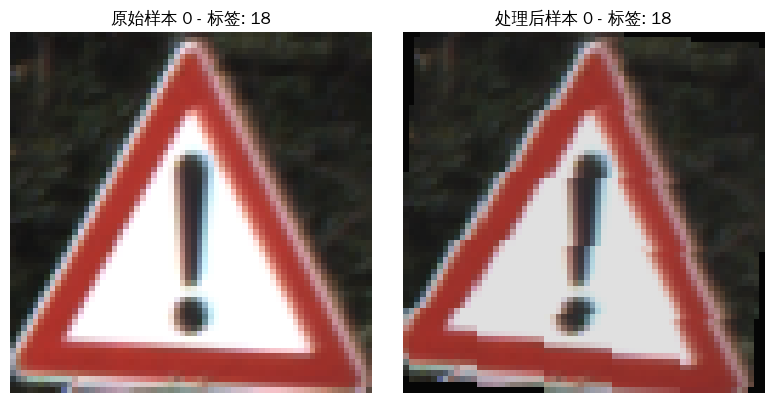

训练集样本: 27446
验证集样本: 5881
测试集样本: 5882
创建CNN模型
模型类型: simple
总参数: 116,715
可训练参数: 116,011
优化器: AdamW
学习率调度: CosineAnnealingDecay
初始学习率: 0.001
开始训练
Epoch 1/50


训练:   0%|          | 0/857 [00:00<?, ?it/s]/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/paddle/nn/layer/norm.py:818: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


保存模型: trained_models/traffic_sign_cnn_paddle_best_20251228_003218.pdparams (val_acc: 0.3959)
训练 - 损失: 2.7341, 准确率: 0.2326
验证 - 损失: 2.0339, 准确率: 0.3959
Epoch 2/50


保存模型: trained_models/traffic_sign_cnn_paddle_best_20251228_003218.pdparams (val_acc: 0.5463)
训练 - 损失: 1.8650, 准确率: 0.4199
验证 - 损失: 1.4242, 准确率: 0.5463
Epoch 3/50


保存模型: trained_models/traffic_sign_cnn_paddle_best_20251228_003218.pdparams (val_acc: 0.7004)
训练 - 损失: 1.3947, 准确率: 0.5584
验证 - 损失: 0.9628, 准确率: 0.7004
Epoch 4/50


保存模型: trained_models/traffic_sign_cnn_paddle_best_20251228_003218.pdparams (val_acc: 0.8067)
训练 - 损失: 1.0736, 准确率: 0.6565
验证 - 损失: 0.6343, 准确率: 0.8067
Epoch 5/50


保存模型: trained_models/traffic_sign_cnn_paddle_best_20251228_003218.pdparams (val_acc: 0.8645)
训练 - 损失: 0.8366, 准确率: 0.7309
验证 - 损失: 0.4450, 准确率: 0.8645
Epoch 6/50


保存模型: trained_models/traffic_sign_cnn_paddle_best_20251228_003218.pdparams (val_acc: 0.8873)
训练 - 损失: 0.6519, 准确率: 0.7906
验证 - 损失: 0.3456, 准确率: 0.8873
Epoch 7/50


保存模型: trained_models/traffic_sign_cnn_paddle_best_20251228_003218.pdparams (val_acc: 0.9444)
训练 - 损失: 0.5131, 准确率: 0.8330
验证 - 损失: 0.2098, 准确率: 0.9444
Epoch 8/50


保存模型: trained_models/traffic_sign_cnn_paddle_best_20251228_003218.pdparams (val_acc: 0.9594)
训练 - 损失: 0.4152, 准确率: 0.8643
验证 - 损失: 0.1368, 准确率: 0.9594
Epoch 9/50


早停计数器: 1/15
训练 - 损失: 0.3495, 准确率: 0.8878
验证 - 损失: 0.2043, 准确率: 0.9429
Epoch 10/50


保存模型: trained_models/traffic_sign_cnn_paddle_best_20251228_003218.pdparams (val_acc: 0.9782)
训练 - 损失: 0.2942, 准确率: 0.9047
验证 - 损失: 0.0819, 准确率: 0.9782
Epoch 11/50


早停计数器: 1/15
训练 - 损失: 0.2594, 准确率: 0.9162
验证 - 损失: 0.0847, 准确率: 0.9769
Epoch 12/50


早停计数器: 2/15
训练 - 损失: 0.2485, 准确率: 0.9216
验证 - 损失: 0.0795, 准确率: 0.9743
Epoch 13/50


保存模型: trained_models/traffic_sign_cnn_paddle_best_20251228_003218.pdparams (val_acc: 0.9784)
早停计数器: 3/15
训练 - 损失: 0.2381, 准确率: 0.9240
验证 - 损失: 0.0660, 准确率: 0.9784
Epoch 14/50


保存模型: trained_models/traffic_sign_cnn_paddle_best_20251228_003218.pdparams (val_acc: 0.9816)
训练 - 损失: 0.2143, 准确率: 0.9313
验证 - 损失: 0.0604, 准确率: 0.9816
Epoch 15/50


保存模型: trained_models/traffic_sign_cnn_paddle_best_20251228_003218.pdparams (val_acc: 0.9833)
训练 - 损失: 0.2057, 准确率: 0.9343
验证 - 损失: 0.0513, 准确率: 0.9833
Epoch 16/50


早停计数器: 1/15
训练 - 损失: 0.1816, 准确率: 0.9411
验证 - 损失: 0.0573, 准确率: 0.9801
Epoch 17/50


早停计数器: 2/15
训练 - 损失: 0.1832, 准确率: 0.9420
验证 - 损失: 0.0510, 准确率: 0.9833
Epoch 18/50


早停计数器: 3/15
训练 - 损失: 0.1726, 准确率: 0.9440
验证 - 损失: 0.0675, 准确率: 0.9796
Epoch 19/50


保存模型: trained_models/traffic_sign_cnn_paddle_best_20251228_003218.pdparams (val_acc: 0.9900)
训练 - 损失: 0.1597, 准确率: 0.9491
验证 - 损失: 0.0371, 准确率: 0.9900
Epoch 20/50


早停计数器: 1/15
训练 - 损失: 0.1666, 准确率: 0.9476
验证 - 损失: 0.0434, 准确率: 0.9866
Epoch 21/50


保存模型: trained_models/traffic_sign_cnn_paddle_best_20251228_003218.pdparams (val_acc: 0.9920)
训练 - 损失: 0.1503, 准确率: 0.9523
验证 - 损失: 0.0293, 准确率: 0.9920
Epoch 22/50


早停计数器: 1/15
训练 - 损失: 0.1467, 准确率: 0.9547
验证 - 损失: 0.0326, 准确率: 0.9905
Epoch 23/50


早停计数器: 2/15
训练 - 损失: 0.1400, 准确率: 0.9561
验证 - 损失: 0.0380, 准确率: 0.9884
Epoch 24/50


保存模型: trained_models/traffic_sign_cnn_paddle_best_20251228_003218.pdparams (val_acc: 0.9923)
早停计数器: 3/15
训练 - 损失: 0.1380, 准确率: 0.9581
验证 - 损失: 0.0250, 准确率: 0.9923
Epoch 25/50


早停计数器: 4/15
训练 - 损失: 0.1333, 准确率: 0.9586
验证 - 损失: 0.0352, 准确率: 0.9893
Epoch 26/50


早停计数器: 5/15
训练 - 损失: 0.1246, 准确率: 0.9610
验证 - 损失: 0.0293, 准确率: 0.9896
Epoch 27/50


早停计数器: 6/15
训练 - 损失: 0.1200, 准确率: 0.9613
验证 - 损失: 0.0332, 准确率: 0.9893
Epoch 28/50


保存模型: trained_models/traffic_sign_cnn_paddle_best_20251228_003218.pdparams (val_acc: 0.9934)
训练 - 损失: 0.1202, 准确率: 0.9617
验证 - 损失: 0.0213, 准确率: 0.9934
Epoch 29/50


保存模型: trained_models/traffic_sign_cnn_paddle_best_20251228_003218.pdparams (val_acc: 0.9949)
训练 - 损失: 0.1206, 准确率: 0.9625
验证 - 损失: 0.0162, 准确率: 0.9949
Epoch 30/50


早停计数器: 1/15
训练 - 损失: 0.1142, 准确率: 0.9653
验证 - 损失: 0.0246, 准确率: 0.9929
Epoch 31/50


早停计数器: 2/15
训练 - 损失: 0.1082, 准确率: 0.9672
验证 - 损失: 0.0182, 准确率: 0.9942
Epoch 32/50


保存模型: trained_models/traffic_sign_cnn_paddle_best_20251228_003218.pdparams (val_acc: 0.9957)
早停计数器: 3/15
训练 - 损失: 0.1045, 准确率: 0.9670
验证 - 损失: 0.0177, 准确率: 0.9957
Epoch 33/50


早停计数器: 4/15
训练 - 损失: 0.1063, 准确率: 0.9677
验证 - 损失: 0.0209, 准确率: 0.9947
Epoch 34/50


早停计数器: 5/15
训练 - 损失: 0.1086, 准确率: 0.9656
验证 - 损失: 0.0276, 准确率: 0.9932
Epoch 35/50


保存模型: trained_models/traffic_sign_cnn_paddle_best_20251228_003218.pdparams (val_acc: 0.9964)
训练 - 损失: 0.0976, 准确率: 0.9696
验证 - 损失: 0.0145, 准确率: 0.9964
Epoch 36/50


早停计数器: 1/15
训练 - 损失: 0.1054, 准确率: 0.9675
验证 - 损失: 0.0228, 准确率: 0.9939
Epoch 37/50


早停计数器: 2/15
训练 - 损失: 0.0980, 准确率: 0.9706
验证 - 损失: 0.0126, 准确率: 0.9961
Epoch 38/50


保存模型: trained_models/traffic_sign_cnn_paddle_best_20251228_003218.pdparams (val_acc: 0.9976)
训练 - 损失: 0.0961, 准确率: 0.9716
验证 - 损失: 0.0113, 准确率: 0.9976
Epoch 39/50


早停计数器: 1/15
训练 - 损失: 0.0967, 准确率: 0.9707
验证 - 损失: 0.0114, 准确率: 0.9973
Epoch 40/50


早停计数器: 2/15
训练 - 损失: 0.0962, 准确率: 0.9714
验证 - 损失: 0.0191, 准确率: 0.9944
Epoch 41/50


早停计数器: 3/15
训练 - 损失: 0.0960, 准确率: 0.9710
验证 - 损失: 0.0142, 准确率: 0.9961
Epoch 42/50


早停计数器: 4/15
训练 - 损失: 0.0951, 准确率: 0.9710
验证 - 损失: 0.0147, 准确率: 0.9954
Epoch 43/50


早停计数器: 5/15
训练 - 损失: 0.0869, 准确率: 0.9731
验证 - 损失: 0.0150, 准确率: 0.9959
Epoch 44/50


早停计数器: 6/15
训练 - 损失: 0.0933, 准确率: 0.9721
验证 - 损失: 0.0156, 准确率: 0.9951
Epoch 45/50


早停计数器: 7/15
训练 - 损失: 0.0896, 准确率: 0.9735
验证 - 损失: 0.0179, 准确率: 0.9951
Epoch 46/50


早停计数器: 8/15
训练 - 损失: 0.0923, 准确率: 0.9721
验证 - 损失: 0.0143, 准确率: 0.9964
Epoch 47/50


早停计数器: 9/15
训练 - 损失: 0.0805, 准确率: 0.9747
验证 - 损失: 0.0254, 准确率: 0.9923
Epoch 48/50


早停计数器: 10/15
训练 - 损失: 0.0927, 准确率: 0.9724
验证 - 损失: 0.0135, 准确率: 0.9973
Epoch 49/50


早停计数器: 11/15
训练 - 损失: 0.0799, 准确率: 0.9761
验证 - 损失: 0.0116, 准确率: 0.9957
Epoch 50/50


早停计数器: 12/15
训练 - 损失: 0.0833, 准确率: 0.9745
验证 - 损失: 0.0118, 准确率: 0.9973
训练时间: 5675.28秒
平均每轮: 113.51秒
最终训练准确率: 0.9745
最终验证准确率: 0.9973
训练-验证差距: -0.0228
最佳验证准确率: 0.9976 - 第38轮
泛化能力良好
模型已保存: my_traffic_classifier_paddle.pdparams
评估模型


测试: 100%|██████████| 184/184 [00:04<00:00, 40.04it/s]


测试集损失: 0.0151
测试集准确率: 0.9961
测试样本数: 5882


[2025-12-28 02:07:01,628] [ WARNING] _mathtext.py:649 - Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
[2025-12-28 02:07:01,632] [ WARNING] _mathtext.py:649 - Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
[2025-12-28 02:07:01,634] [ WARNING] _mathtext.py:649 - Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
[2025-12-28 02:07:01,637] [ WARNING] _mathtext.py:649 - Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
[2025-12-28 02:07:01,639] [ WARNING] _mathtext.py:649 - Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
[2025-12-28 02:07:01,641] [ WARNING] _mathtext.py:649 - Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
[2025-12-28 02:07:01,736] [ WARNING] _mathtext.py:649 - Font 'default' does not have a glyph for '\u

训练曲线已保存: training_curves/training_history111_20251228_003218.png


[2025-12-28 02:07:02,960] [ WARNING] _mathtext.py:649 - Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
[2025-12-28 02:07:02,963] [ WARNING] _mathtext.py:649 - Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
[2025-12-28 02:07:02,965] [ WARNING] _mathtext.py:649 - Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
[2025-12-28 02:07:02,968] [ WARNING] _mathtext.py:649 - Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
[2025-12-28 02:07:02,970] [ WARNING] _mathtext.py:649 - Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
[2025-12-28 02:07:02,972] [ WARNING] _mathtext.py:649 - Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


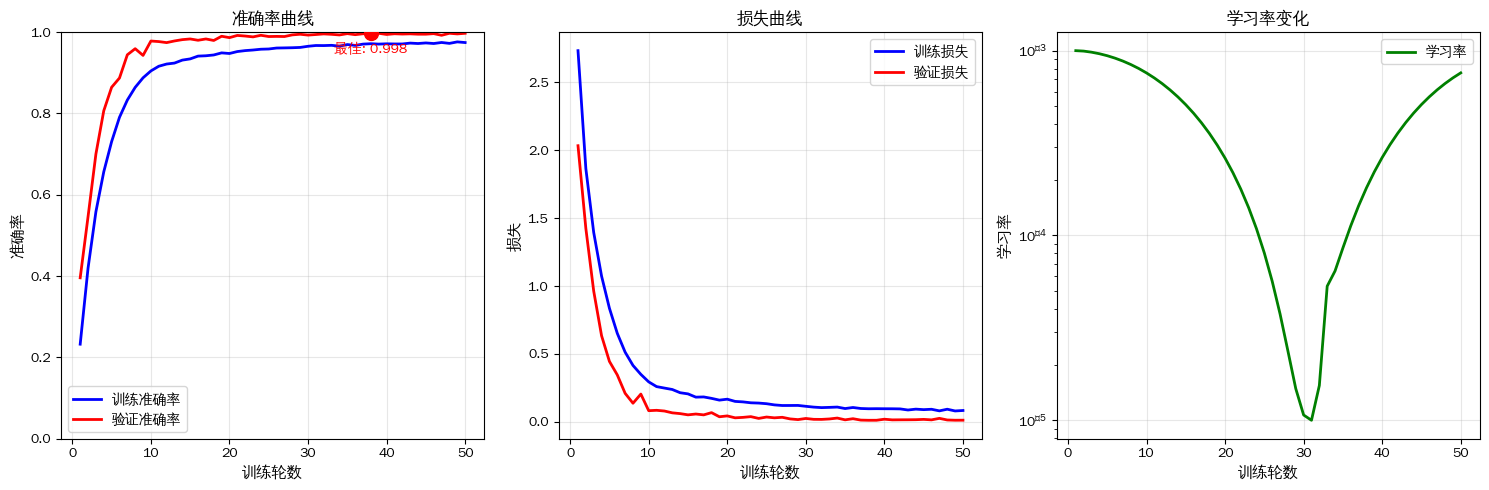

模型名称: traffic_sign_cnn_paddle
训练时间: 20251228_003218
训练设备: iluvatar_gpu:0
训练轮数: 50
训练用时: 5675.28秒
最终训练准确率: 0.9745
最终验证准确率: 0.9973
训练-验证差距: -0.0228
最佳验证准确率: 0.9976
测试集准确率: 0.9961
测试样本数: 5882
过拟合状态: 优秀泛化
训练报告已保存: training_results/training_report111_20251228_003218.json
训练流程完成，模型已保存


In [5]:
def main():
    print("德国交通标志识别 - CNN模型训练")
    
    trainer = CNNTrainerPaddle(
        model_name='traffic_sign_cnn_paddle',
        image_size=(64, 64)
    )
    
    history = trainer.train_model(
        epochs=50,
        batch_size=32,
        model_type='simple',
        learning_rate=0.001,
        optimizer_type='adam'
    )
    
    if history is not None:
        print("训练流程完成，模型已保存")

if __name__ == "__main__":
    print(f"PaddlePaddle版本: {paddle.__version__}")
    print(f"NumPy版本: {np.__version__}")
    
    if not os.path.exists('processed_data'):
        os.makedirs('processed_data', exist_ok=True)
    
    main()